Version 2.1: Support multiple formats of output.

C:\Users\World\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\World\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(
C:\Users\World\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but SVR was fitted without feature names
  warnings.warn(
C:\Users\World\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:27

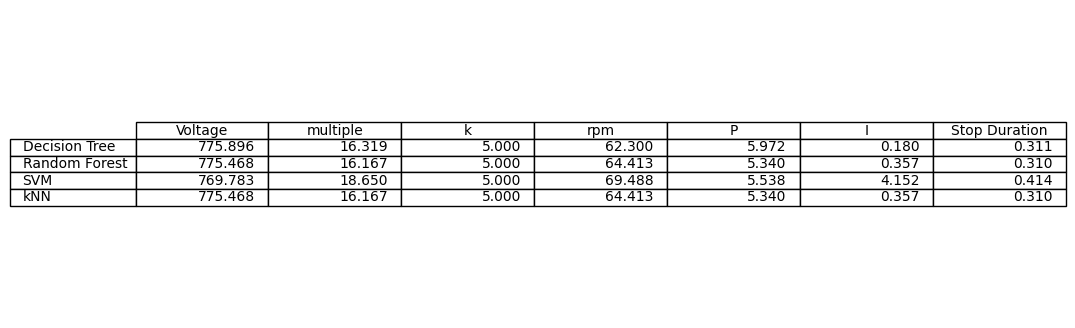

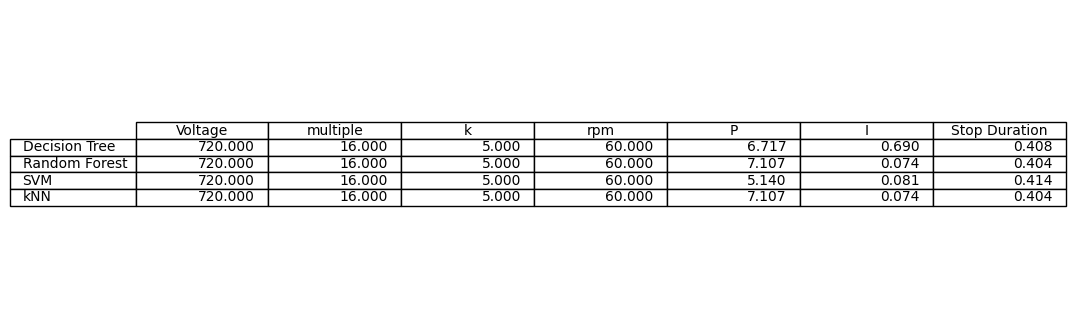

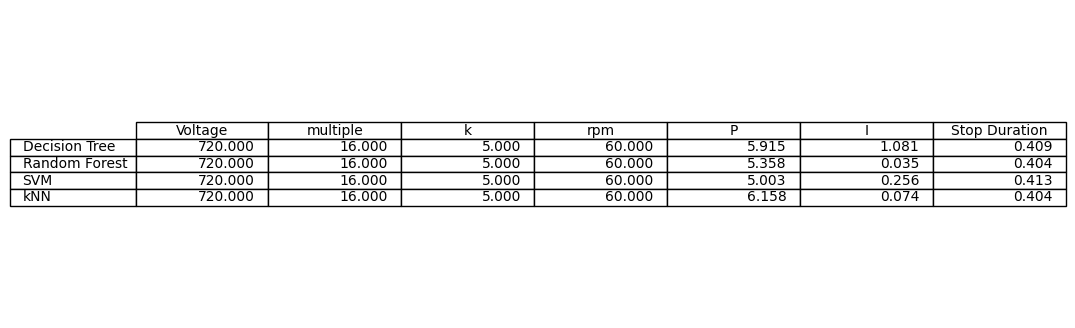

In [1]:
from tkinter import *
import pandas as pd
import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn import neighbors
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

root = Tk()
root.title("AI-Based Overvoltage Control Parameter Prediction")
root.geometry("750x445")

fr_main = Frame(root)

fr_title = Frame(fr_main)
lab_title = Label(fr_title, text="Enter known parameters and click \'Confirm\' to get the best set of parameters.")
lab_title.grid(row=0, column=0)
fr_title.grid(row=0, column=0, pady=20, columnspan=2)

fr_input = Frame(fr_main)
fr_output = Frame(fr_main)
fr_save = Frame(fr_main)

names=['Voltage Threshold', 'J-weight', 'Slope', 'Stop rpm Threshold', 'P', 'I', "Stop Duration"]
names_o=['Voltage', 'multiple', 'k', 'rpm', 'P', 'I']
border = [[710, 780], [16, 20], [5, 5.000001], [60, 70], [5, 50], [0.01, 5.0119]]
algo_names = ['Decision Tree', 'Random Forest', 'SVM', 'kNN']
algo_alias = ['DTR', 'RFR', 'SVM', 'kNN']
table_tags = ['Algorithm', 'Voltage', 'J-weight', 'Slope', 'Stop rpm', 'P', 'I', 'Duration']

var = [StringVar() for i in range(6)]
lab = [None for i in range(6)]
lab_grid = [[None for j in range(5)] for i in range(8)]
ent = [None for i in range(6)]

algorithm = [IntVar() for i in range(4)]

def FindAnswer(algo_ind, pred, quest):
    a = np.where(pred == min(pred))
    res = []
    for i in range(6):
        res.append(quest[names_o[i]][a[0]].iloc[0])
    res.append(min(pred))
    return [algo_ind, res]

def Prediction(algo_bool, quest):
    # 1. 加载CSV数据
    data = pd.read_csv('cleaned_file.csv')

    # 2. 假设特征在data的前几列，标签在最后一列
    X = data.iloc[:, :-1].values  # 输入特征
    y = data.iloc[:, -1].values   # 输出标签

    # 3. 数据分割为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    prediction = []
    if algo_bool[0]:
        regressor = DecisionTreeRegressor(max_depth = 17, min_samples_leaf = 2, min_samples_split = 19) 
        regressor.fit(X_train, y_train)
        prediction.append(FindAnswer(0, regressor.predict(quest), quest))
    if algo_bool[1]:
        random_forest_regressor = RandomForestRegressor(n_estimators=100, max_depth=17, max_features=5, random_state=0)
        random_forest_regressor.fit(X_train, y_train)
        prediction.append(FindAnswer(1, random_forest_regressor.predict(quest), quest))
    if algo_bool[2]:
        regressor = SVR(kernel='rbf', C=1, epsilon=0.01, gamma='auto')
        regressor.fit(X_train, y_train)
        prediction.append(FindAnswer(2, regressor.predict(quest), quest))
    if algo_bool[3]:
        n_neighbors = 5
        knn = neighbors.KNeighborsRegressor(n_neighbors, weights="distance")
        knn_regressor = knn.fit(X_train, y_train)
        prediction.append(FindAnswer(3, knn_regressor.predict(quest), quest))
        
    return prediction


def SaveFileExcel(pred_res):                   # openpyxl needed
    pred_res.to_excel("Results.xlsx")
def SaveFileCSV(pred_res):
    pred_res.to_csv("Results.csv")
def SaveFilePDF(pred_res):
    fig, ax =plt.subplots(figsize=(12,4))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=pred_res.values, colLabels=pred_res.columns, rowLabels=pred_res.index, loc='center')
    pp = PdfPages("Results.pdf")
    pp.savefig(fig, bbox_inches='tight')
    pp.close()


def callback():
    if not(valid_all()):
        return
        
    data = {
        'Voltage' : [],
        'multiple' : [],
        'k' : [],
        'rpm' : [],
        'P' : [],
        'I' : []
    }
    to_pred = []
    for i in range(6):
        if var[i].get() == "0":
            to_pred.append(i)
    
    random_amount = 10000
    for i in range(random_amount):
        for j in range(6):
            if j in to_pred:
                data[names_o[j]].append(random.uniform(border[j][0],border[j][1]))
            else:
                data[names_o[j]].append(float(var[j].get()))
    quest = pd.DataFrame(data)

    
    algo_bool = []
    for i in range(4):
        algo_bool.append(algorithm[i].get())
    prediction = Prediction(algo_bool, quest)

    pred_algo = []
    pred_data = {
        'Voltage' : [],
        'multiple' : [],
        'k' : [],
        'rpm' : [],
        'P' : [],
        'I' : [],
        'Stop Duration' : []
    }
    pred_data_tags = ['Voltage', 'multiple', 'k', 'rpm', 'P', 'I', 'Stop Duration']

    algo_cnt = len(prediction)
    lab_grid[0][0] = Label(fr_output, text="")
    lab_grid[0][0].grid(row=1, column=0, pady=5)
    for i in range(algo_cnt):
        pred_algo.append(algo_names[prediction[i][0]])
        if lab_grid[0][i+1] != None :
            lab_grid[0][i+1].grid_forget()
        lab_grid[0][i+1] = Label(fr_output, text=algo_alias[prediction[i][0]])
        lab_grid[0][i+1].grid(row=1, column=i+1, pady=5, padx=5)
    for i in range(algo_cnt, 4):
        if lab_grid[0][i+1] != None :
            lab_grid[0][i+1].grid_forget()

    for i in range(7):
        lab_grid[i+1][0] = Label(fr_output, text=names[i]+" : ")
        lab_grid[i+1][0].grid(row=i+2, column=0, sticky='e', pady=5)
        for j in range(algo_cnt):
            pred_data[pred_data_tags[i]].append('{:.3f}'.format(prediction[j][1][i]))
            
            if lab_grid[i+1][j+1] != None:
                lab_grid[i+1][j+1].grid_forget()
            lab_grid[i+1][j+1] = Label(fr_output, text='{:.3f}'.format(prediction[j][1][i]))
            lab_grid[i+1][j+1].grid(row=i+2, column=j+1, sticky='e', pady=5, padx=5)
        for j in range(algo_cnt, 4):
            if lab_grid[i+1][j+1] != None:
                lab_grid[i+1][j+1].grid_forget()

    pred_res = pd.DataFrame(pred_data, index=pred_algo)

    button_save_excel = Button(fr_save, text='Save as Excel', command=SaveFileExcel(pred_res), relief='groove')
    button_save_excel.grid(row=0, column=0, sticky='w', padx=5)
    button_save_csv = Button(fr_save, text='Save as CSV', command=SaveFileCSV(pred_res), relief='groove')
    button_save_csv.grid(row=0, column=1, sticky='w', padx=5)
    button_save_pdf = Button(fr_save, text='Save as PDF', command=SaveFilePDF(pred_res), relief='groove')
    button_save_pdf.grid(row=0, column=2, sticky='w', padx=5)
    fr_save.grid(row=2, column=1, sticky='w', padx=5)


def valid_all():
    flag = 1
    for i in range(6):
        try:
            float(var[i].get())
        except ValueError:
            flag = False
    if flag:
        #print("Start predicting.")
        lab_ill.grid_forget()
        return 1
    else:
        #print("Illegal input!")
        lab_ill.grid(row=10, column=0, pady=5)
        return 0
    

for i in range(6):
    var[i].set("0")
lab_ill = Label(fr_input, text="Illegal input!")
for i in range(6):
    lab[i] = Label(fr_input, text=names[i]+" : ")
    lab[i].grid(row=i, column=0, sticky='e', pady=5)
    ent[i] = Entry(fr_input, validate='focusout', textvariable=var[i])
    ent[i].grid(row=i, column=1, sticky='w', pady=5)

lab_algo = Label(fr_input, text="Choose Algorithm:")
lab_algo.grid(row=6, column=0, pady=5)


algo_choice = [None for i in range(4)]
for i in range(4):
    algo_choice[i] = Checkbutton(fr_input, variable=algorithm[i], text=algo_names[i])
algo_choice[0].grid(row=7, column=0, sticky='w', pady=5)
algo_choice[2].grid(row=7, column=1, sticky='w', pady=5)
algo_choice[1].grid(row=8, column=0, sticky='w', pady=5)
algo_choice[3].grid(row=8, column=1, sticky='w', pady=5)
    

button = Button(fr_input, text='Confirm', command=callback, relief='groove')
button.grid(row=9, column=0, columnspan=2, pady=10)

lab_intro = Label(fr_output, text="Best set(s) of parameters:")
lab_intro.grid(row=0, column=0, columnspan=2, pady=10, sticky='nw')


fr_input.grid(row=1, column=0, sticky='nw', padx=16, rowspan=2)
fr_output.grid(row=1, column=1, sticky='nw', padx=16)

fr_main.grid(row=0, column=0, padx=10, pady=6)

mainloop()
